# HOG + SVM 毛笔书体检测

**训练数据存放于阿里网盘中 /训练数据/毛笔书体训练数据.zip**

- 读取数据
- 提取HOG特征
- 送至SVM训练
- 评估模型
- 保存模型
- 可视化训练效果

In [1]:
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath("."))))

In [92]:
# 导入模块
import random

import cv2
import pathlib
import matplotlib.pyplot as plt

import pylab
import joblib
import pandas as pd
import seaborn as sn


from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from skimage import exposure
from skimage.feature import hog

from utils.image import read_image

pylab.rcParams["font.sans-serif"] = ["SimHei"]

In [3]:
# 指定训练数据文件夹
train_data_path = pathlib.Path("E:\TrainData\毛笔书体训练数据")

In [4]:
chen_img_path = pathlib.Path(train_data_path, "草书", "陈", "智永_6a3c02fcf9f72ac36f3bd971c593b1d07eed2898.jpg")
img_1 = read_image(str(chen_img_path))
img_1_fixed = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

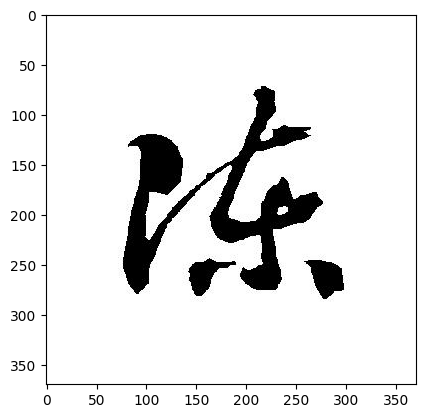

In [5]:
plt.imshow(img_1_fixed)

## 提取HOG特征

Text(0.5, 1.0, 'Histogram of Oriented Gradients')

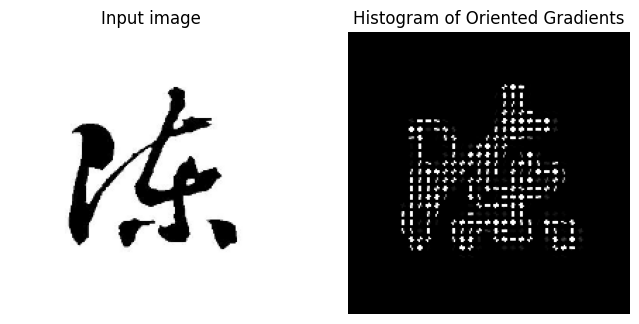

In [49]:
# 缩放原图
image_1_fixed_resize = cv2.resize(img_1_fixed, (200, 200))
image_1_fixed_resize_gray = cv2.cvtColor(image_1_fixed_resize, cv2.COLOR_RGB2GRAY)

# 转化为灰度图
# fd, hog_image = hog(image=image_1_fixed_resize_gray, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
fd, hog_image = hog(image=image_1_fixed_resize_gray, orientations=4, pixels_per_cell=(6, 6), cells_per_block=(2, 2), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(image_1_fixed_resize)
ax1.set_title("Input image")

hog_image_recaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_recaled, cmap=plt.cm.gray)
ax2.set_title("Histogram of Oriented Gradients")


In [26]:
for index, item in enumerate(train_data_path.glob("*")):
    print(index, item)

0 E:\TrainData\毛笔书体训练数据\楷书
1 E:\TrainData\毛笔书体训练数据\篆书
2 E:\TrainData\毛笔书体训练数据\草书
3 E:\TrainData\毛笔书体训练数据\行书
4 E:\TrainData\毛笔书体训练数据\隶书


In [77]:
# 特征列表
feature_list = []
# 标签列表
label_list = []
# 类别标签的映射关系
label_map = {}

for index, item in enumerate(train_data_path.glob("*")):
    # 字体类别
    style = item.name
    # 保存映射关系
    label_map[index] = style
    # 遍历每个类别下的所有图片文件
    file_list = list(item.glob("**/*"))
    # 随机打乱文件获取有限的图片
    random.shuffle(file_list)

    # 选取前1000个文件
    selected_files = file_list[:3000]

    print(f"开始遍历 {style} 风格的图片特征")

    # 遍历选择的文件进行特征提取
    for file_path in selected_files:
        if not file_path.is_file():
            continue

        # 读取图片内容, 进行灰度处理
        image = read_image(str(file_path))
        # 缩放
        image = cv2.resize(image, (100, 100))
        # 灰度
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 提取hog特征
        fd = hog(image=image, orientations=4, pixels_per_cell=(6, 6), cells_per_block=(2, 2))

        # 添加类别标签
        label_list.append(index)
        # 添加特征
        feature_list.append(fd)


开始遍历 楷书 风格的图片特征
开始遍历 篆书 风格的图片特征
开始遍历 草书 风格的图片特征
开始遍历 行书 风格的图片特征
开始遍历 隶书 风格的图片特征


## SVM模型训练

In [78]:
# 划分训练集和测试样本
x_train, x_test, y_train, y_test = train_test_split(feature_list, label_list, test_size=0.25, random_state=42)

In [79]:
# 训练,  核函数, rbf: 0.7568590350047304, linear: 0.6830652790917692, poly: 0.7464522232734153
cls = svm.SVC(kernel="rbf")
cls.fit(x_train, y_train)

SVC()

In [80]:
predicted_labels = cls.predict(x_test)

In [81]:
accuracy_score(y_test, predicted_labels)

0.7748427672955975

## 保存模型

In [84]:
joblib.dump(cls, "./models/hog_svm.joblib")

['./models/hog_svm.joblib']

In [85]:
cls = joblib.load("./models/hog_svm.joblib")

In [86]:
predicted_labels = cls.predict(x_test)
accuracy_score(y_test, predicted_labels)

0.7748427672955975

In [88]:
cm = confusion_matrix(y_test, predicted_labels)
cm

array([[512,  18,  44,  37,  48],
       [ 28, 450,  27,  10,  15],
       [ 32,  10, 464, 167,  10],
       [ 35,  12, 132, 517,   6],
       [ 46,  15,  15,   9, 521]], dtype=int64)

<Axes: >

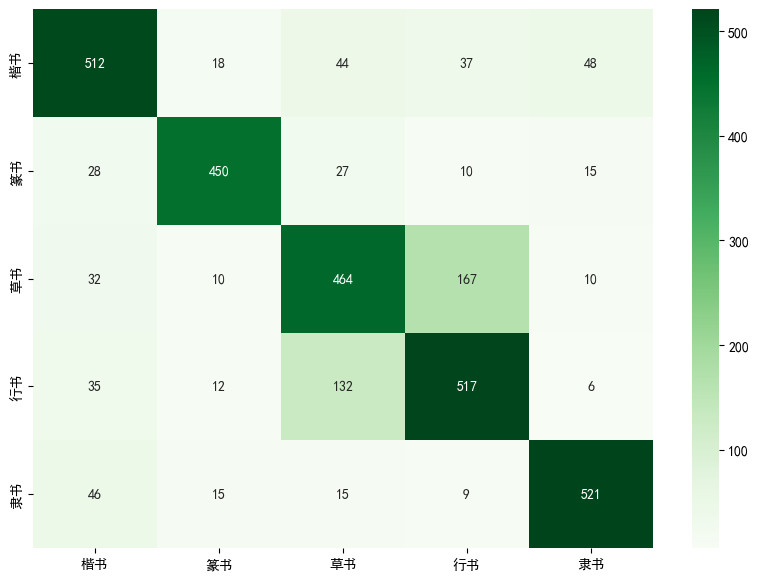

In [93]:
df_cm = pd.DataFrame(cm, index=list(label_map.values()), columns=list(label_map.values()))
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap="Greens", fmt="d")

## 预测马晓楠同学的书法风格

In [118]:
file_path = pathlib.Path("./resources/test_imgs/dan.jpg")

In [119]:
image = read_image(file_path)
image = cv2.resize(image, (100, 100))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

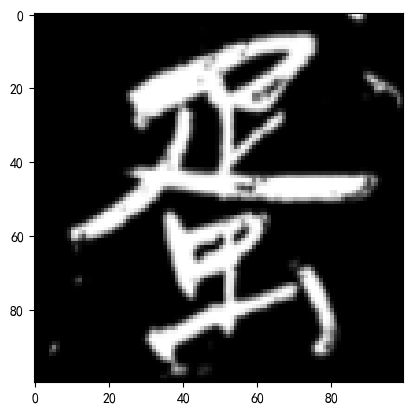

In [120]:
plt.imshow(image, cmap=plt.cm.gray)

In [121]:
fd = hog(image=image, orientations=4, pixels_per_cell=(6, 6), cells_per_block=(2, 2))

In [122]:
res = cls.predict([fd])
print(f"马晓楠同学的书法风格为: {label_map[res[0]]}")

马晓楠同学的书法风格为: 楷书
